# Running TB HIV scenarios

Usage sample (with scenarios and plotting)


To use the hiv comorbidity features, you will need to add these 3 things to the simulation:
- `HIV disease` to the disease list: Configure it as requested. Also, please note that if no intervention is specified, the model will use a initial prevalence and art coverage as specified in the HIV disease.
- `TB_HIV connector` to the connector list: You will have the hability to update the values of each modifier as specified in the connector.
- `HivIntervention` to the intervention list: The same intervention can be used for managing the art coverage and the prevalence depending on the specified parameters.




In [6]:
# Import required packages
import matplotlib.pyplot as plt
import numpy as np
import sciris as sc
import tbsim
import starsim as ss

## Build TB-HIV Simulation



In [ ]:

def build_tbhiv_sim(simpars=None, tbpars=None, hivinv_pars=None) -> ss.Sim:
    """Build a TB-HIV simulation with current disease and intervention models."""
    
    # Set up the simulation parameters:
    default_simpars = dict(
        dt=ss.days(7),
        start=ss.date('1980-01-01'), stop=ss.date('2025-12-31'),
        rand_seed=123,
        verbose=0,
    )
    if simpars: default_simpars.update(simpars)
    
    # People:
    n_agents = 1000
    extra_states = [ss.FloatArr('SES', default=ss.bernoulli(p=0.3))]
    people = ss.People(n_agents=n_agents, extra_states=extra_states)

    # Disease 1: TB:
    pars = dict(beta=ss.peryear(0.01), init_prev=ss.bernoulli(p=0.25), rel_sus_latentslow=0.1)
    if tbpars:
        pars.update(tbpars)
    tb = tbsim.TB(pars=pars)

    # Disease 2: HIV:
    hiv_pars = dict(init_prev=ss.bernoulli(p=0.10), init_onart=ss.bernoulli(p=0.50))
    hiv = tbsim.HIV(pars=hiv_pars)

    # Network:
    network = ss.RandomNet(pars=dict(n_contacts=ss.poisson(lam=2), dur=0))

    # Connector: TB-HIV
    connector = tbsim.TB_HIV_Connector()
    
    # Interventions: HivInterventions 
    interventions = []
    if hivinv_pars is not None:
        hiv.update_pars(hiv_pars)
        hivinv_pars = hivinv_pars or dict(
            use_prevalence=True,
            use_art=True,
            prevalence=0.20, 
            percent_on_ART=0.20,
            min_age=15, 
            max_age=49,
            start=ss.date('2000-01-01'), stop=ss.date('2010-12-31'),
        )
        hiv_intervention = tbsim.HivInterventions(pars=hivinv_pars)
        interventions = [hiv_intervention]

    # Create the simulation:
    sim = ss.Sim(
        people=people,
        diseases=[tb, hiv],
        interventions=interventions,
        networks=network,
        connectors=[connector],
        pars=default_simpars,
    )
    return sim

## Run HIV Intervention Scenarios
This function runs multiple intervention strategies, each with varying HIV prevalence, ART coverage, and target age ranges.

In [ ]:
def run_scenarios():
   
    """Run the scenarios and return the results."""
    scenarios = {
        'baseline': None,
        'early_low_delivery_both':      dict(use_prevalence=True, use_art=True, prevalence=0.10, percent_on_ART=0.10, 
                                        min_age=15, max_age=49,
                                        start=ss.date('1990-01-01'), stop=ss.date('2000-12-31')),
        
        'high_coverage_delivery_both':  dict(use_prevalence=True, use_art=True, prevalence=0.25, percent_on_ART=0.75, 
                                        min_age=10, max_age=60,
                                        start=ss.date('2000-01-01'), stop=ss.date('2025-12-31')), 
        
        'infection_1990_delivery':     dict(use_prevalence=True, use_art=False, prevalence=0.10, 
                                        min_age=15, max_age=49,
                                        start=ss.date('1990-01-01'), stop=ss.date('2000-12-31')),
        
        'infection_2000_delivery':     dict(use_prevalence=True, use_art=False, prevalence=0.25,  
                                        min_age=10, max_age=60,
                                        start=ss.date('2000-01-01'), stop=ss.date('2025-12-31')), 
        
        'early_art_delivery':           dict(use_prevalence=False, use_art=True, percent_on_ART=0.10, 
                                        min_age=15, max_age=49,
                                        start=ss.date('1990-01-01'), stop=ss.date('2025-12-31')),
        
        'high_art_delivery':            dict(use_prevalence=False, use_art=True, percent_on_ART=0.75, 
                                        min_age=10, max_age=60,
                                        start=ss.date('2000-01-01'), stop=ss.date('2025-12-31')), 
    }
    flat_results = {}
    for name, hivinv_pars in scenarios.items():
        print(f'Running scenario: {name}')
        sim = build_tbhiv_sim(hivinv_pars=hivinv_pars)
        sim.run()
        flat_results[name] = sim.results.flatten()
    return flat_results

## Plotting Results
We extract relevant metrics across scenarios and generate time series plots to visualize their trends. Metrics can be filtered by keywords or exclusions.

In [12]:
def plot_results(flat_results, keywords=None, exclude=['15']):
    metrics = sorted({k for flat in flat_results.values() for k in flat.keys() if (not keywords or any(kw in k for kw in keywords))}, reverse=True)
    metrics = [m for m in metrics if not any(excl in m for excl in exclude)]
    n_metrics = len(metrics)
    if n_metrics > 0:
        n_cols = 5
        n_rows = int(np.ceil(n_metrics / n_cols))
        fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*2))
        axs = axs.flatten()
    cmap = plt.cm.get_cmap('tab10', len(flat_results))
    for i, metric in enumerate(metrics):
        ax = axs[i]
        for j, (scenario, flat) in enumerate(flat_results.items()):
            if metric in flat:
                result = flat[metric]
                ax.plot(result.timevec, result.values, label=scenario, color=cmap(j))
        ax.set_title(metric)
        ax.set_ylabel('%' if max(result.values) < 1 else 'Value')
        ax.set_xlabel('Time')
        ax.grid(True)
        ax.legend(loc='upper right', fontsize=6 if len(flat_results) <= 5 else 5)
        ax.set_facecolor('#f0f0f0')
    plt.tight_layout()
    plt.savefig(f'{sc.thisdir()}/tbhiv_scenarios.png', dpi=300)
    plt.show()

## Plotting

Running scenario: baseline
Running scenario: early_low_delivery_both
HIV intervention present, skipping initialization.


/Users/mine/git/hivtb/tbsim/comorbidities/hiv/intervention.py:112: RuntimeWarning: 
Not enough acute cases to revert. Expected: 1, Available: 0
  ss.warn(msg=f"Not enough acute cases to revert. Expected: {-delta}, Available: {len(acute_uids)}")


Running scenario: high_coverage_delivery_both
HIV intervention present, skipping initialization.


/Users/mine/git/hivtb/tbsim/comorbidities/hiv/intervention.py:112: RuntimeWarning: 
Not enough acute cases to revert. Expected: 1, Available: 0
  ss.warn(msg=f"Not enough acute cases to revert. Expected: {-delta}, Available: {len(acute_uids)}")


Running scenario: infection_1990_delivery
HIV intervention present, skipping initialization.


/Users/mine/git/hivtb/tbsim/comorbidities/hiv/intervention.py:112: RuntimeWarning: 
Not enough acute cases to revert. Expected: 1, Available: 0
  ss.warn(msg=f"Not enough acute cases to revert. Expected: {-delta}, Available: {len(acute_uids)}")
/Users/mine/git/hivtb/tbsim/comorbidities/hiv/intervention.py:112: RuntimeWarning: 
Not enough acute cases to revert. Expected: 2, Available: 0
  ss.warn(msg=f"Not enough acute cases to revert. Expected: {-delta}, Available: {len(acute_uids)}")


Running scenario: infection_2000_delivery
HIV intervention present, skipping initialization.


/Users/mine/git/hivtb/tbsim/comorbidities/hiv/intervention.py:112: RuntimeWarning: 
Not enough acute cases to revert. Expected: 1, Available: 0
  ss.warn(msg=f"Not enough acute cases to revert. Expected: {-delta}, Available: {len(acute_uids)}")
/Users/mine/git/hivtb/tbsim/comorbidities/hiv/intervention.py:112: RuntimeWarning: 
Not enough acute cases to revert. Expected: 2, Available: 0
  ss.warn(msg=f"Not enough acute cases to revert. Expected: {-delta}, Available: {len(acute_uids)}")
/Users/mine/git/hivtb/tbsim/comorbidities/hiv/intervention.py:112: RuntimeWarning: 
Not enough acute cases to revert. Expected: 3, Available: 0
  ss.warn(msg=f"Not enough acute cases to revert. Expected: {-delta}, Available: {len(acute_uids)}")


Running scenario: early_art_delivery
HIV intervention present, skipping initialization.


/Users/mine/git/hivtb/tbsim/comorbidities/hiv/intervention.py:139: RuntimeWarning: 
Not enough candidates for ART. Expected: 19, Available: 0
  ss.warn(msg=f"Not enough candidates for ART. Expected: {delta}, Available: {len(candidates)}")
/Users/mine/git/hivtb/tbsim/comorbidities/hiv/intervention.py:139: RuntimeWarning: 
Not enough candidates for ART. Expected: 18, Available: 0
  ss.warn(msg=f"Not enough candidates for ART. Expected: {delta}, Available: {len(candidates)}")
/Users/mine/git/hivtb/tbsim/comorbidities/hiv/intervention.py:139: RuntimeWarning: 
Not enough candidates for ART. Expected: 17, Available: 0
  ss.warn(msg=f"Not enough candidates for ART. Expected: {delta}, Available: {len(candidates)}")
/Users/mine/git/hivtb/tbsim/comorbidities/hiv/intervention.py:139: RuntimeWarning: 
Not enough candidates for ART. Expected: 16, Available: 0
  ss.warn(msg=f"Not enough candidates for ART. Expected: {delta}, Available: {len(candidates)}")
/Users/mine/git/hivtb/tbsim/comorbidities/hi

Running scenario: high_art_delivery
HIV intervention present, skipping initialization.


/Users/mine/git/hivtb/tbsim/comorbidities/hiv/intervention.py:139: RuntimeWarning: 
Not enough candidates for ART. Expected: 133, Available: 0
  ss.warn(msg=f"Not enough candidates for ART. Expected: {delta}, Available: {len(candidates)}")
/Users/mine/git/hivtb/tbsim/comorbidities/hiv/intervention.py:139: RuntimeWarning: 
Not enough candidates for ART. Expected: 132, Available: 0
  ss.warn(msg=f"Not enough candidates for ART. Expected: {delta}, Available: {len(candidates)}")
/Users/mine/git/hivtb/tbsim/comorbidities/hiv/intervention.py:139: RuntimeWarning: 
Not enough candidates for ART. Expected: 131, Available: 0
  ss.warn(msg=f"Not enough candidates for ART. Expected: {delta}, Available: {len(candidates)}")
/Users/mine/git/hivtb/tbsim/comorbidities/hiv/intervention.py:139: RuntimeWarning: 
Not enough candidates for ART. Expected: 130, Available: 0
  ss.warn(msg=f"Not enough candidates for ART. Expected: {delta}, Available: {len(candidates)}")
/Users/mine/git/hivtb/tbsim/comorbiditie

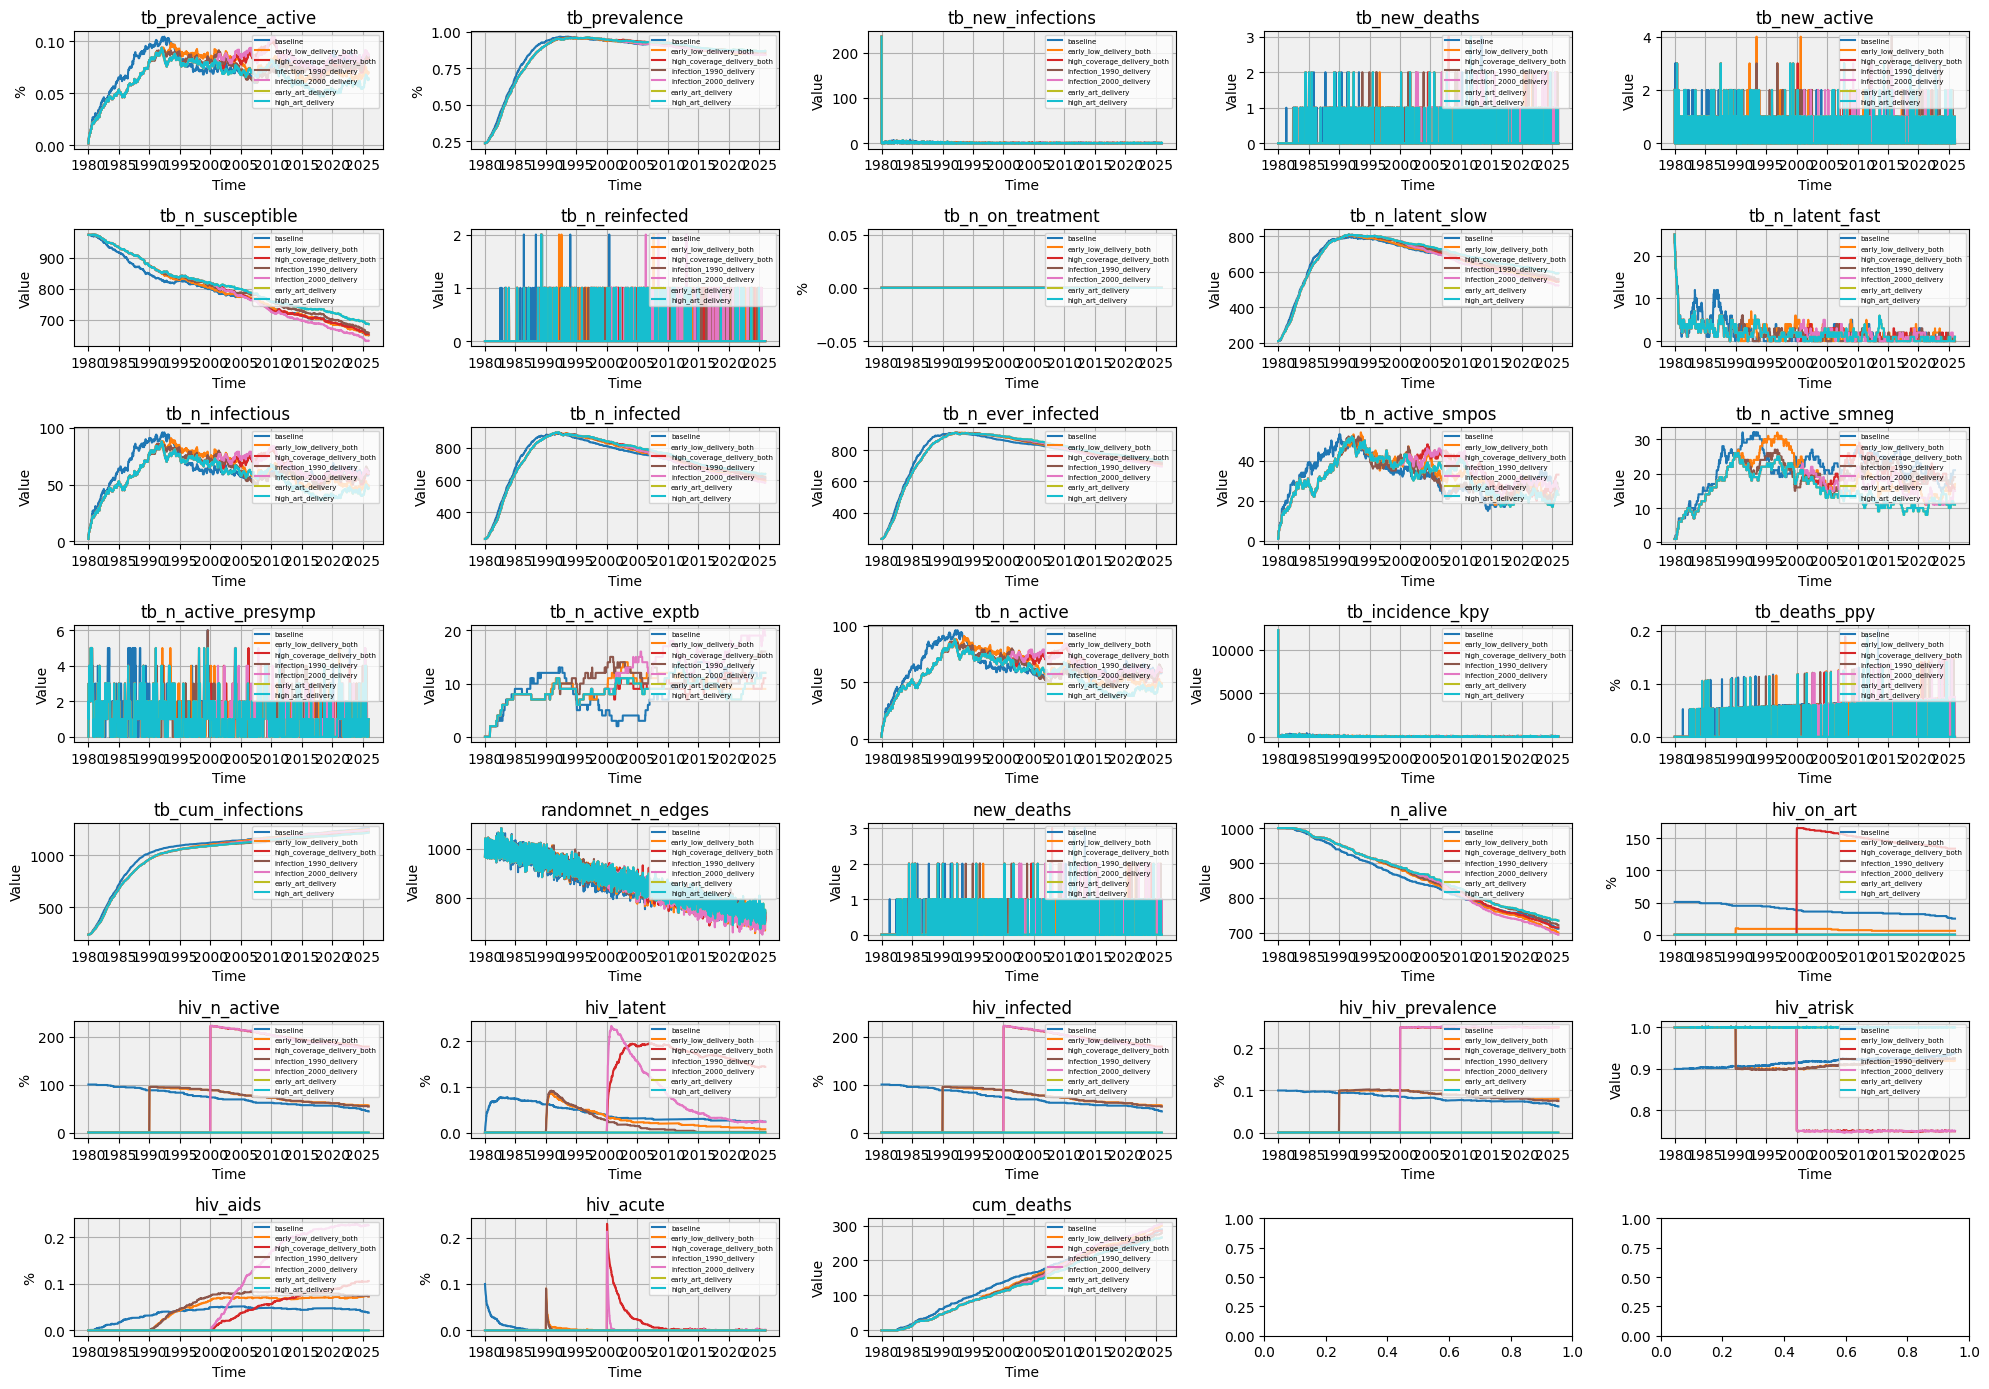

In [13]:
# Run everything
flat_results = run_scenarios()
plot_results(flat_results)